<a href="https://colab.research.google.com/github/AnkurMali/IST597_SP21/blob/main/ISTSP21_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(len(test_dataset))
# batch_size, channel, h ,w or 
# batch_size, h,w, channel

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


In [23]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(16, 5, padding='same', activation=None)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(16, 5, 2, padding='same', activation=None)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(32, 5, padding='same', activation=None)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv2D(32, 5, 2, padding='same', activation=None)
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.batch5 = tf.keras.layers.BatchNormalization()
        self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        self.batch6 = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.batch7 = tf.keras.layers.BatchNormalization()
        self.conv8 = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch8 = tf.keras.layers.BatchNormalization()
        self.conv9 = tf.keras.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch9 = tf.keras.layers.BatchNormalization()
        self.conv10 = tf.keras.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.conv11 = tf.keras.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch11 = tf.keras.layers.BatchNormalization()
        self.conv12 = tf.keras.layers.Conv2D(num_classes, 3, 2, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
       
    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = self.batch1(x, training=training)
        x = self.conv2(x)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.batch3(x, training=training)
        x = self.conv4(x)
        x = self.batch4(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv5(x)
        x = self.batch5(x, training=training)
        x = self.conv6(x)
        x = self.batch6(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv7(x)
        x = self.batch7(x, training=training)
        x = self.conv8(x)
        x = self.batch8(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv9(x)
        x = self.batch9(x, training=training)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.batch11(x, training=training)
        x = self.conv12(x)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        #print(x.shape)
        return x
    
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss
    
    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    def compute_accuracy(self, input_data):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            acc = tf.metrics.Accuracy()
            for step ,(images, targets) in enumerate(input_data):
                # Predict the probability of each class
                print(targets.shape)
                logits = self.predict(images, training=False)
                # Select the class with the highest probability
                print(logits.shape)
                logits = tf.reshape(logits, [-1, 10])
                preds = tf.argmax(logits, axis=1)
                # Compute the accuracy
                print(preds.shape)
                acc(tf.reshape(targets, [-1,]), preds)
        return acc
        
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, False)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, False)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [24]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
model = ImageRecognitionCNN(num_classes=10, device=device, 
                              checkpoint_directory=checkpoint_directory)

#model = ImageRecognitionCNN(num_classes=7, device=device)

In [6]:
# Train model
model.fit_fc(train_dataset, test_dataset, optimizer, num_epochs=10, 
          early_stopping_rounds=2, verbose=2, train_from_scratch=True)

Train loss at epoch 1:  0.138215
Eval loss at epoch 1:  0.13550562
Train loss at epoch 2:  0.04169017
Eval loss at epoch 2:  0.052632973
Train loss at epoch 4:  0.018545043
Eval loss at epoch 4:  0.039416026
Train loss at epoch 6:  0.009227915
Eval loss at epoch 6:  0.035779044
Train loss at epoch 8:  0.012281994
Eval loss at epoch 8:  0.04949995


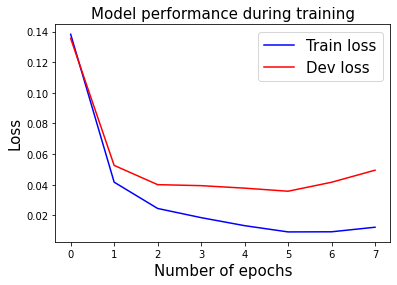

In [7]:
plt.plot(range(len(model.history['train_loss'])), model.history['train_loss'],
         color='b', label='Train loss');
plt.plot(range(len(model.history['eval_loss'])), model.history['eval_loss'], 
         color='r', label='Dev loss');
plt.title('Model performance during training', fontsize=15)
plt.xlabel('Number of epochs', fontsize=15);
plt.ylabel('Loss', fontsize=15);
plt.legend(fontsize=15);

# Assignment 01000
# Integrated gradients
In this assignment you will implement integrated gradients and write a visualization script to show comparsion between integrated gradients and derivative based approach.
All experiments should be conducted on FashionMNIST dataset or above (cifar10, cifar100).

Normally for derivated based approach our first attempt would be to understand the predictions of your model by directly computing the derivative of the output class with respect to the image. This is very basic step and can give you a hint on which part of the image activated the network. However, this technique is believed to be sensitive to image artifacts.

To avoid this we are going to use integrated gradients to compute the attributions of the network for a certain image. Especially you are required to look at formulation provided in main equation 3. Students are advised to read the main article and try implementing the function.
[Integrated Gradient](http://proceedings.mlr.press/v70/sundararajan17a/sundararajan17a.pdf)

This assignment might serve as first step towards understanding prediction our your convolution neural network.

In short things to do in this assignment.

* You will use our above codebase and adjust the number of hidden layers (minimum number of hidden layers > 2), you will report various model performance (accuracy and loss). You will experiment with minimum 3 models, in other model1 shallower model might contain 3 hidden layers, model 2 might contain 4 hidden layers and so on. 
* Take top 5 images and compare integrated gradients with gradients at the image (Look at figure 2 in [Integrated Gradient](http://proceedings.mlr.press/v70/sundararajan17a/sundararajan17a.pdf))
* In short you will have 15 figures, 5 per model.
* Report your findings

Extra things to try for better understanding of CNN's
* Do you think adding more layers is always beneficial ?
* Fixed learning vs dynamic rating
* Play with activation function such as elu, relu6, leakyrelu.
* Play with optimizers.
* Play with kernel size, output_channel.
